# VAE Analysis

## The previous Model and it's shortcomings. 
#### First let's load the model and plot the 5000 examples and 4 red points + 1 extra red point, from 03_02_autoencoder_analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch as t
import torch.nn as nn

from models.Autoencoder import Autoencoder
from torchvision import datasets, transforms
from scipy.stats import norm

In [2]:
test_ds = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=True)

device = t.device('cuda' if t.cuda.is_available() else 'cpu')
prev_model = Autoencoder(test_ds[0][0][None], in_c=1, enc_out_c=[32, 64, 64, 64],
                    enc_ks=[3, 3, 3, 3], enc_pads=[1, 1, 0, 1], enc_strides=[1, 2, 2, 1],
                    dec_out_c=[64, 64, 32, 1], dec_ks=[3, 3, 3, 3], dec_strides=[1, 2, 2, 1],
                    dec_pads=[1, 0, 1, 1], dec_op_pads=[0, 1, 1, 0], z_dim=2)
prev_model.cuda(device)
prev_model.load_state_dict(t.load('03_01.pth'))
prev_model.eval()

t.set_grad_enabled(False)
encoder = prev_model.enc_conv_layers
decoder = prev_model.dec_conv_layers

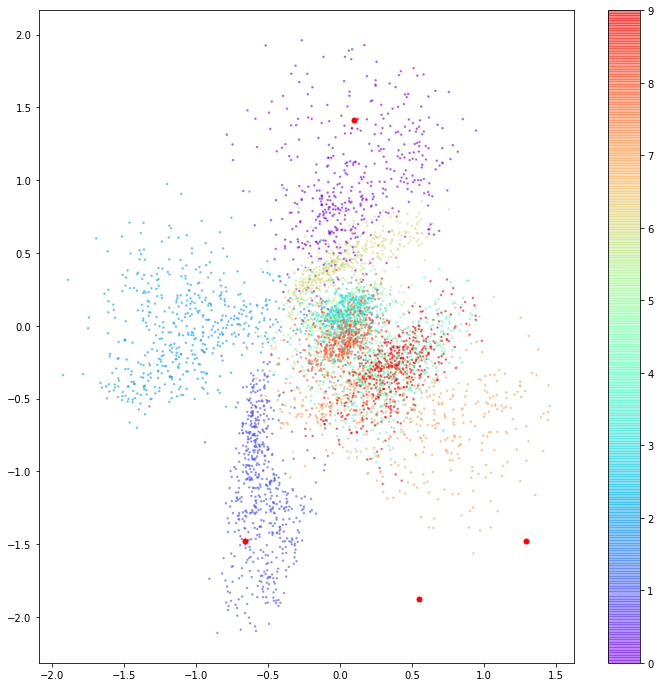

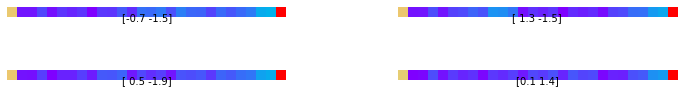

In [3]:
test_dl = t.utils.data.DataLoader(dataset=test_ds, batch_size=5000, shuffle=False, drop_last=True)

figsize = 12
np.random.seed(42)

examples = next(iter(test_dl))
x, y = examples[0], examples[1]
z_points = encoder(x.to(device)).cpu()

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], cmap='rainbow', c=y, alpha=0.5, s=2)
plt.colorbar()

grid_size = 2
grid_depth = 2

zx_min, zx_max, zy_min, zy_max = min(z_points[:, 0]), max(z_points[:, 0]), min(z_points[:, 1]), max(z_points[:, 1])
x = np.random.uniform(zx_min, zx_max, size = grid_size * grid_depth)
y = np.random.uniform(zy_min, zy_max, size = grid_size * grid_depth)

z_grid = np.array(list(zip(x, y)))
reconst = decoder(t.from_numpy(z_grid).float().to(device)).cpu()

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=25)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size * grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)    
    ax.imshow(reconst[i, :,:,0], cmap = 'rainbow')

[-0.7 -1.5]	     [ 1.3 -1.5]	     [ 0.5 -1.9]	     [0.1 1.4]	     [ 0.1 -0.2]	     

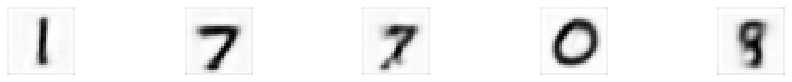

In [4]:
z_points = t.tensor([[-.7, -1.5], [1.3, -1.5], [.5, -1.9], [0.1, 1.4], [.1, -.2]])
bs = len(z_points)
reconst_imgs = decoder(z_points.to(device))

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for z_point in z_points:
    print(z_point.numpy(), end='\t     ')
    
for i in range(bs):
    img = reconst_imgs[i].cpu().squeeze()
    ax = fig.add_subplot(2, bs, i + bs + 1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')


In [5]:
zx_min, zx_max, zy_min, zy_max

(tensor(-1.9228), tensor(1.4542), tensor(-2.1091), tensor(1.9611))

## Now we ask the question, why did [0.5, -1.9], the 7, and [.1, -.2], the 8, look off?
### First as discussed, [.5, -1.9] is an outlier, from clusters within our zx_min, zx_max, zy_min and zy_max bounds.
### The underlying issue is that, the points are not dispersed within our latent space well enough to keep the bounds to what should be well within distinguishable and clear numbers, when decoded. Let's test this theory again with plotting decoded spaces, truly close to the bounds. 

[-1.9228177 -2.1090848]	         [-1.9228177  1.4541827]	         [ 1.4541827 -2.1090848]	         [1.4541827 1.961089 ]	         

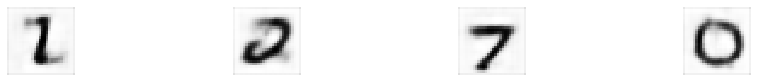

In [6]:
z_points = t.tensor([[zx_min, zy_min], [zx_min, zx_max], [zx_max, zy_min], [zx_max, zy_max]])
bs = len(z_points)
reconst_imgs = decoder(z_points.to(device))

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for z_point in z_points:
    print(z_point.numpy(), end='\t         ')
    
for i in range(bs):
    img = reconst_imgs[i].cpu().squeeze()
    ax = fig.add_subplot(2, bs, i + bs + 1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')


#### Above you can see the numbers have smears of black, and the first two are not really clear what number it's to be

## Now let's look at a bigger problem(IMO), which is demonstrated by plotting decoded [.1, -.2], (i.e the 8 from cell 4). I suspect smearings have to do partially do this cause.

### essentially our Neural network didn't have enough say in where to map a class of images to and thus had a hard time plotting similar images to encodings that are around the same range of points. For this reason, we added the Lambda layer from VariationalAutoencoder.py that helps us sample similar points for similar images. The two vectors, mu and log_var, gives a multivariate normal distribution around some point in the latent space, which is a better mapping that just a straight 1-vector(two points) mapping.

#### Examples [.1, -.2] is having a hard time deciding b/w 8 and 9. Let's demonstrate by plotting more points around this points

In [7]:
linspace = list(zip(np.linspace(.1, .15, 8), np.linspace(-.1, -.15, 8)))
z_points = t.tensor(linspace)
z_points

tensor([[ 0.1000, -0.1000],
        [ 0.1071, -0.1071],
        [ 0.1143, -0.1143],
        [ 0.1214, -0.1214],
        [ 0.1286, -0.1286],
        [ 0.1357, -0.1357],
        [ 0.1429, -0.1429],
        [ 0.1500, -0.1500]])

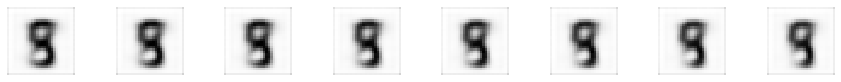

In [8]:
bs = len(z_points)
reconst_imgs = decoder(z_points.to(device))

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(bs):
    img = reconst_imgs[i].cpu().squeeze()
    ax = fig.add_subplot(2, bs, i + bs + 1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')


###  Remember that a net's job is to reduce loss, however if our loss doesn't tell it to try to map similar images to similar distributions of point spaces, it can't disperse and cluster well around those points. So how do we tell that? 

### We add to our loss function, another loss(KL) that makes it so that our Net has to be trained in a way to do well with this additional loss to minimize, which will be small when log_var - mu ** 2 - log_var.exp() is close to -1

## Now, with Variational Auto Encoding

In [9]:
import torch as t
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import tqdm
from models.VariationalAutoencoder import VariationalAutoencoder
from torchvision import datasets, transforms


In [10]:
test_ds = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=True)

device = t.device('cuda' if t.cuda.is_available() else 'cpu')
model = VariationalAutoencoder(test_ds[0][0][None], in_c=1, enc_out_c=[32, 64, 64, 64],
                    enc_ks=[3, 3, 3, 3], enc_pads=[1, 1, 0, 1], enc_strides=[1, 2, 2, 1],
                    dec_out_c=[64, 64, 32, 1], dec_ks=[3, 3, 3, 3], dec_strides=[1, 2, 2, 1],
                    dec_pads=[1, 0, 1, 1], dec_op_pads=[0, 1, 1, 0], z_dim=2)
model.cuda(device)
model.load_state_dict(t.load('03_02.pth'))
model.eval()

t.set_grad_enabled(False)
encoder = model.enc_conv_layers
decoder = model.dec_conv_layers

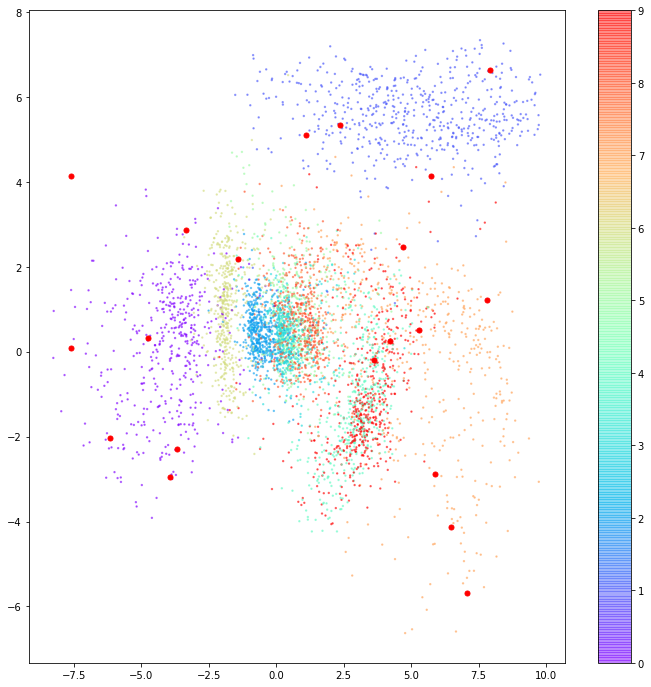

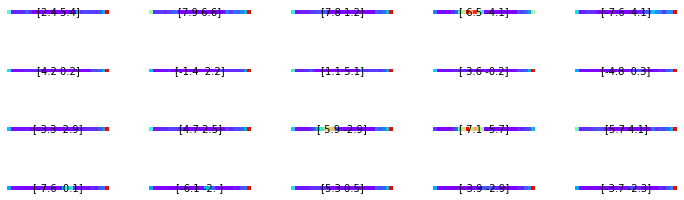

In [11]:
test_dl = t.utils.data.DataLoader(dataset=test_ds, batch_size=5000, shuffle=False, drop_last=True)

figsize = 12
np.random.seed(20)

examples = next(iter(test_dl))
x, y = examples[0], examples[1]
z_points = encoder(x.to(device))[0].cpu()

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], cmap='rainbow', c=y, alpha=0.5, s=2)
plt.colorbar()

grid_size = 5
grid_depth = 4

zx_min, zx_max, zy_min, zy_max = min(z_points[:, 0]), max(z_points[:, 0]), min(z_points[:, 1]), max(z_points[:, 1])
x = np.random.uniform(zx_min, zx_max, size = grid_size * grid_depth)
y = np.random.uniform(zy_min, zy_max, size = grid_size * grid_depth)

z_grid = np.array(list(zip(x, y)))
reconst = decoder(t.from_numpy(z_grid).float().to(device)).cpu()

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=25)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size * grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)    
    ax.imshow(reconst[i, :,:,0], cmap = 'rainbow')

[2.3561864 5.3507376]	     [7.939655  6.6378307]	     [7.8281417 1.2174104]	     [ 6.46298 -4.13058]	     [-7.6037345  4.130405 ]	     [4.2251425  0.24942742]	     [-1.4213369  2.1890304]	     [1.1005607 5.0975523]	     [ 3.6154337 -0.1883162]	     [-4.7548428   0.32706955]	     [-3.3396697  2.861646 ]	     [4.7093644 2.4618425]	     [ 5.8708057 -2.873359 ]	     [ 7.0850253 -5.6872654]	     [5.730874  4.1470704]	     [-7.589762    0.09024868]	     [-6.146395 -2.029606]	     [5.298669  0.5044621]	     [-3.9366105 -2.9455173]	     [-3.6554773 -2.290714 ]	     

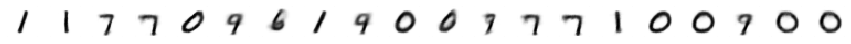

In [12]:
z_points = t.tensor(z_grid).float()
bs = len(z_points)
reconst_imgs = decoder(z_points.to(device))

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for z_point in z_points:
    print(z_point.numpy(), end='\t     ')
    
for i in range(bs):
    img = reconst_imgs[i].cpu().squeeze()
    ax = fig.add_subplot(2, bs, i + bs + 1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')


In [13]:
zx_min, zx_max, zy_min, zy_max

(tensor(-8.2510), tensor(9.7844), tensor(-6.6276), tensor(7.3393))

[-8.2510195 -6.6275783]	     [-8.2510195  9.784434 ]	     [ 9.784434  -6.6275783]	     [9.784434  7.3392587]	     

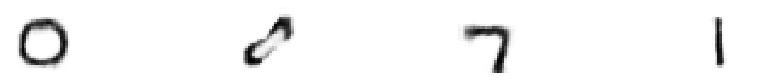

In [14]:
z_points = t.tensor([[zx_min, zy_min], [zx_min, zx_max], [zx_max, zy_min], [zx_max, zy_max]])
bs = len(z_points)
reconst_imgs = decoder(z_points.to(device))

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for z_point in z_points:
    print(z_point.numpy(), end='\t     ')
    
for i in range(bs):
    img = reconst_imgs[i].cpu().squeeze()
    ax = fig.add_subplot(2, bs, i + bs + 1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')


## Although, the second 0 above came out weird, which I think is harder to address, the smears are all mostly gone, even in cell 12. Also, similar numbers mapped to similar points in space, and looks more distinguishable. This VAE isn't perfect, but it seemed to help, even if the individual loss was higher than the regular encoder. Perhaps, due to the additional loss requirement?